In [2]:
import numpy as np
import itertools
import warnings
import matplotlib.pyplot as plt

import tenpy

from tenpy.networks.site import Site, SpinHalfFermionSite, SpinHalfSite, GroupedSite, SpinSite
from tenpy.tools.misc import to_iterable, to_iterable_of_len, inverse_permutation
from tenpy.networks.mps import MPS  # only to check boundary conditions

from tenpy.models.lattice import Lattice, _parse_sites
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.models.tf_ising import TFIChain
from tenpy.tools.params import get_parameter


from tenpy.algorithms import dmrg

# statistics
from scipy.optimize import curve_fit
from scipy import stats

__all__ = ['KitaevLadder', 'Ising1D']

In [3]:
class KitaevLadder(Lattice):    
    """ A ladder coupling two chains of the Kitaev form
    .. image :: /images/lattices/Ladder.*
    Parameters
    ----------
    L : int
        The length of each chain, we have 2*L sites in total.
    sites : (list of) :class:`~tenpy.networks.site.Site`
        The two local lattice sites making the `unit_cell` of the :class:`Lattice`.
        If only a single :class:`~tenpy.networks.site.Site` is given, it is used for both chains.
    **kwargs :
        Additional keyword arguments given to the :class:`Lattice`.
        `basis`, `pos` and `pairs` are set accordingly.
    """
    dim = 1

    def __init__(self, L, sites, **kwargs):
        sites = _parse_sites(sites, 4)
        basis = np.array([[2., 0.]])
        pos = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
        kwargs.setdefault('basis', basis)
        kwargs.setdefault('positions', pos)
        kwargs.setdefault('bc', 'periodic')
        kwargs.setdefault('bc_MPS', 'infinite')
        
        NNz = [(0, 1, np.array([0])), (2, 3, np.array([0]))]
        NNx = [(1, 3, np.array([0])), (2, 0, np.array([1]))]
        NNy = [(0, 2, np.array([0])), (3, 1, np.array([1]))]
        nNNa = [(1, 2, np.array([0])), (3, 0, np.array([1]))]
        nNNb = [(0, 3, np.array([0])), (2, 1, np.array([1]))]
        
        kwargs.setdefault('pairs', {})
        kwargs['pairs'].setdefault('nearest_neighbors_x', NNx)
        kwargs['pairs'].setdefault('nearest_neighbors_y', NNy)
        kwargs['pairs'].setdefault('nearest_neighbors_z', NNz)
        kwargs['pairs'].setdefault('next_nearest_neighbors_a', nNNa)
        kwargs['pairs'].setdefault('next_nearest_neighbors_b', nNNb)
        
        Lattice.__init__(self, [L], sites, **kwargs)
        

class Ising1D(CouplingMPOModel):
    def __init__(self, model_params):
        CouplingMPOModel.__init__(self, model_params)

    def init_sites(self, model_params):
        conserve = get_parameter(model_params, 'conserve', 'parity', self.name)
        fs = SpinHalfSite(conserve=conserve)
        return [fs, fs, fs, fs]

    def init_lattice(self, model_params):
        L = get_parameter(model_params, 'L', 3, self.name)
        gs = self.init_sites(model_params)
        model_params.pop("L")
        lat = KitaevLadder(L, gs)
        return lat

    def init_terms(self, model_params):
        Jz = get_parameter(model_params, 'Jz', 1., self.name, True)
        g = get_parameter(model_params, 'g', 1., self.name, True)
        
        # onsite terms
        for u in range(len(self.lat.unit_cell)):
            self.add_onsite(-g, u, 'Sigmaz')

        # coupling terms
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_z']:
            self.add_coupling(-Jz, u1, 'Sigmax', u2, 'Sigmax', dx)
#         for u1, u2, dx in self.lat.pairs['nearest_neighbors_x']:
#             self.add_coupling(-Jx, u1, 'Sz', u2, 'Sz', dx)
#         for u1, u2, dx in self.lat.pairs['nearest_neighbors_y']:
#             self.add_coupling(-Jy, u1, 'Sy', u2, 'Sy', dx)
        for u1, u2, dx in self.lat.pairs['next_nearest_neighbors_a']:
            self.add_coupling(-Jz, u1, 'Sigmax', u2, 'Sigmax', dx)
    pass

        
def plot_lattice():
    fig, ax = plt.subplots()
    lat = KitaevLadder(5, None, bc='periodic')
    links_name = 'nearest_neighbors_z'
    lat.plot_coupling(ax, lat.pairs[links_name], linewidth=5.)
    lat.plot_coupling(ax, lat.pairs['next_nearest_neighbors_a'], linewidth=5.)
    # print(lat.pairs['nearest_neighbors'])
    print(lat.unit_cell)
    lat.plot_order(ax=ax, linestyle='--')
    lat.plot_sites(ax)
    # lat.plot_basis(ax, color='g', linewidth=3.)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    # plt.title(links_name)
    plt.show()


[None, None, None, None]


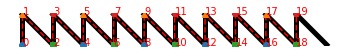

In [4]:
plot_lattice()

In [5]:
def run(calc_correlation=True):

    model_params = dict(conserve='parity', Jz=1., g=1., L=1, verbose=1)
    prod_state = ["up", "up"] * (2 * model_params['L'])
    M = Ising1D(model_params)
    psi = MPS.from_product_state(
        M.lat.mps_sites(), 
        prod_state, 
        bc=M.lat.bc_MPS,
    )

    dmrg_params = {
        'start_env': 10,
#         'mixer': False,  # setting this to True helps to escape local minima
        'mixer': True,
        'mixer_params': {
            'amplitude': 1.e-4,
            'decay': 1.2,
            'disable_after': 100
        },
        'trunc_params': {
            'chi_max': 4,
            'svd_min': 1.e-10,
        },
        'max_E_err': 1.e-10,
        'max_S_err': 1.e-5,
        'max_sweeps': 10000,
        'verbose': 1.,
    }
    
    
#     eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    
    # we will return this data dictionary in the end, for the further investigation
    data = dict(
        chi_list=[],
        energy_list=[], 
        entropy_list=[], 
        correlation_list=[],
    )
    
#     chi_list = np.arange(4, 129)
    chi_list = [int(2**i) for i in np.arange(4, 7, 0.5)]
    data['chi_list'] = chi_list
    for chi in chi_list:
        
        print("\n")
        print("=" * 80)
        print("="*30 + "START" + "="*30)
        print("=" * 80)
        print("Chi = ", chi, '\n')
        
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
        eng.reset_stats()
        eng.trunc_params['chi_max'] = chi
        info = eng.run()
#         print("INFO: \n", info)

        print("Before the canonicalization:")
        print("Bond dim = ", psi.chi)
        
        print("Canonicalizing...")
        psi_before = psi.copy()
        psi.canonical_form()
        ov = psi.overlap(psi_before, charge_sector=0)
        print("The norm is: ",psi.norm)
        print("The overlap is: ", ov)
        print("After the canonicalization:")
        print("Bond dim = ", psi.chi)
        
        print("Computing properties")
        
        energy=info[0]
        data['energy_list'].append(energy)
        
        entropy = np.mean(psi.entanglement_entropy())
        data['entropy_list'].append(entropy)
        
        if calc_correlation:
            correlation = psi.correlation_length()
            data['correlation_list'].append(correlation)
        
        print("Optimizing")
        tenpy.tools.optimization.optimize(3)
        print("Loop for chi=%d done." % chi)
        print("=" * 80)
        print("="*30 + " END " + "="*30)
        print("=" * 80)
        pass
        
    return data


In [6]:
def plot_results(data):

    chi_list = data['chi_list']
    energy_list = data['energy_list']
    entropy_list = data['entropy_list']
    correlation_list = data['correlation_list']
    
    plt.plot(chi_list, energy_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Ground Energy $E$")
    plt.show()
    
    plt.plot(chi_list, entropy_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Entanglement Entropy $S$")
    plt.show()
    
    plt.plot(chi_list, correlation_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Correlation Length $\xi$")
    plt.show()
    
    plt.plot(np.log(correlation_list), entropy_list, '-o')
    plt.xlabel(r"log Correlation Length $\xi$")
    plt.ylabel(r"Entanglement Entropy $S$")
    plt.show()

In [24]:
data = run()

parameter 'verbose'=1 for Ising1D
parameter 'L'=1 for Ising1D
parameter 'conserve'='parity' for Ising1D
parameter 'Jz'=1.0 for Ising1D
parameter 'g'=1.0 for Ising1D


==============================START==============================
Chi =  16 

parameter 'verbose'=1.0 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........
parameter 'max_sweeps'=10000 for DMRG
parameter 'max_E_err'=1e-10 for DMRG
parameter 'max_S_err'=1e-05 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 0.0001, 'decay': 1.2, 'disable_after': 100} for Sweep
Updating environment
.....
sweep 10, age = 204
Energy = -1.2732297456008759, S = nan, norm_err = 1.9e-03
Current memory usage 174.0 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.8102e-10, max_E_trunc = 2.2087e-09
MPS bond dimensions: [16, 16, 16, 16]
Updating environment
.....
sweep 20

Updating environment
.....
sweep 200, age = 2484
Energy = -1.2732389661186403, S = 0.7621356269385068, norm_err = 1.6e-05
Current memory usage 174.0 MB, time elapsed: 30.7 s
Delta E = 4.6612e-12, Delta S = 2.7171e-05 (per sweep)
max_trunc_err = 3.3785e-08, max_E_trunc = 2.1042e-07
MPS bond dimensions: [16, 16, 16, 16]
Updating environment
.....
sweep 210, age = 2604
Energy = -1.2732389660694139, S = 0.7623400791883979, norm_err = 1.2e-05
Current memory usage 174.0 MB, time elapsed: 31.8 s
Delta E = 4.9226e-12, Delta S = 2.0445e-05 (per sweep)
max_trunc_err = 3.3854e-08, max_E_trunc = 2.1085e-07
MPS bond dimensions: [16, 16, 16, 16]
Updating environment
.....
sweep 220, age = 2724
Energy = -1.2732389660230865, S = 0.7624935914275580, norm_err = 1.0e-05
Current memory usage 174.0 MB, time elapsed: 32.9 s
Delta E = 4.6327e-12, Delta S = 1.5351e-05 (per sweep)
max_trunc_err = 3.3908e-08, max_E_trunc = 2.1119e-07
MPS bond dimensions: [16, 16, 16, 16]
Updating environment
.....
sweep 230, ag

Updating environment
.....
sweep 150, age = 1884
Energy = -1.2732393449134634, S = 0.7983791285016105, norm_err = 2.2e-05
Current memory usage 174.0 MB, time elapsed: 23.8 s
Delta E = -1.1283e-11, Delta S = 7.1407e-05 (per sweep)
max_trunc_err = 1.0861e-08, max_E_trunc = 7.3392e-08
MPS bond dimensions: [22, 22, 22, 22]
Updating environment
.....
sweep 160, age = 2004
Energy = -1.2732393449811070, S = 0.7989605030880577, norm_err = 1.9e-05
Current memory usage 174.0 MB, time elapsed: 24.8 s
Delta E = -6.7644e-12, Delta S = 5.8137e-05 (per sweep)
max_trunc_err = 1.0950e-08, max_E_trunc = 7.3973e-08
MPS bond dimensions: [22, 22, 22, 22]
Updating environment
.....
sweep 170, age = 2124
Energy = -1.2732393450141331, S = 0.7994517211100908, norm_err = 1.8e-05
Current memory usage 174.0 MB, time elapsed: 25.9 s
Delta E = -3.3026e-12, Delta S = 4.9122e-05 (per sweep)
max_trunc_err = 1.1026e-08, max_E_trunc = 7.4472e-08
MPS bond dimensions: [22, 22, 22, 22]
Updating environment
.....
sweep 180,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.....
Updating environment
.....
DMRG finished after 260 sweeps.
total size = 3324, maximum chi = 22
Before the canonicalization:
Bond dim =  [22, 22, 22, 22]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000082134664+0j)
After the canonicalization:
Bond dim =  [22, 22, 22, 22]
Computing properties
Optimizing
Loop for chi=22 done.
============================== END ==============================


==============================START==============================
Chi =  32 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -1.2732335557072112, S = nan, norm_err = 6.6e-02
Current memory usage 174.0 MB, time elapsed: 5.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.0206e-09, max_E_trunc = 2.0889e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 20, age = 324
Energy = -1.2732380134997001, S = nan, norm_err = 7.0e-03
Current memory usage 174.0 MB, time elapsed: 10.7 s
Delta

Updating environment
.....
sweep 200, age = 2484
Energy = -1.2732395014749613, S = 0.8749850889389682, norm_err = 6.3e-05
Current memory usage 174.0 MB, time elapsed: 47.0 s
Delta E = -3.0252e-11, Delta S = 5.9149e-05 (per sweep)
max_trunc_err = 2.6005e-09, max_E_trunc = 1.7335e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 210, age = 2604
Energy = -1.2732395016399209, S = 0.8736977082425735, norm_err = 6.0e-05
Current memory usage 174.0 MB, time elapsed: 48.1 s
Delta E = -1.6496e-11, Delta S = -1.2874e-04 (per sweep)
max_trunc_err = 2.5492e-09, max_E_trunc = 1.6983e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 220, age = 2724
Energy = -1.2732395016876694, S = 0.8747289918889719, norm_err = 8.9e-05
Current memory usage 174.0 MB, time elapsed: 49.2 s
Delta E = -4.7748e-12, Delta S = 1.0313e-04 (per sweep)
max_trunc_err = 2.4967e-09, max_E_trunc = 1.6643e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 230

Updating environment
.....
sweep 410, age = 5004
Energy = -1.2732395018135776, S = 0.8706356672213569, norm_err = 1.1e-04
Current memory usage 174.0 MB, time elapsed: 70.5 s
Delta E = 1.7656e-11, Delta S = -1.7355e-04 (per sweep)
max_trunc_err = 2.3375e-09, max_E_trunc = 1.5591e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 420, age = 5124
Energy = -1.2732395021573666, S = 0.8710695798812095, norm_err = 4.4e-05
Current memory usage 174.0 MB, time elapsed: 71.9 s
Delta E = -3.4379e-11, Delta S = 4.3391e-05 (per sweep)
max_trunc_err = 2.3321e-09, max_E_trunc = 1.5560e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 430, age = 5244
Energy = -1.2732395020784679, S = 0.8720727276006867, norm_err = 6.1e-05
Current memory usage 174.0 MB, time elapsed: 72.9 s
Delta E = 7.8899e-12, Delta S = 1.0031e-04 (per sweep)
max_trunc_err = 2.3290e-09, max_E_trunc = 1.5541e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 440, 

Updating environment
.....
sweep 620, age = 7524
Energy = -1.2732395019988871, S = 0.8716476935288464, norm_err = 8.1e-05
Current memory usage 174.0 MB, time elapsed: 93.8 s
Delta E = 1.1937e-11, Delta S = 1.2801e-04 (per sweep)
max_trunc_err = 2.3134e-09, max_E_trunc = 1.5447e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 630, age = 7644
Energy = -1.2732395018126681, S = 0.8699394828310452, norm_err = 1.1e-04
Current memory usage 174.0 MB, time elapsed: 94.9 s
Delta E = 1.8622e-11, Delta S = -1.7082e-04 (per sweep)
max_trunc_err = 2.3192e-09, max_E_trunc = 1.5478e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 640, age = 7764
Energy = -1.2732395021641878, S = 0.8704429077122348, norm_err = 4.6e-05
Current memory usage 174.0 MB, time elapsed: 96.1 s
Delta E = -3.5152e-11, Delta S = 5.0342e-05 (per sweep)
max_trunc_err = 2.3157e-09, max_E_trunc = 1.5463e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 650, 

Updating environment
.....
sweep 830, age = 10044
Energy = -1.2732395019379510, S = 0.8699213217451818, norm_err = 8.5e-05
Current memory usage 174.0 MB, time elapsed: 117.0 s
Delta E = 1.6166e-11, Delta S = -1.5225e-04 (per sweep)
max_trunc_err = 2.3134e-09, max_E_trunc = 1.5454e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 840, age = 10164
Energy = -1.2732395022014771, S = 0.8702288388049522, norm_err = 1.7e-05
Current memory usage 174.0 MB, time elapsed: 118.2 s
Delta E = -2.6353e-11, Delta S = 3.0752e-05 (per sweep)
max_trunc_err = 2.3096e-09, max_E_trunc = 1.5425e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 850, age = 10284
Energy = -1.2732395020857439, S = 0.8714756365094461, norm_err = 5.6e-05
Current memory usage 174.0 MB, time elapsed: 119.3 s
Delta E = 1.1573e-11, Delta S = 1.2468e-04 (per sweep)
max_trunc_err = 2.3136e-09, max_E_trunc = 1.5445e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep

Updating environment
.....
sweep 1040, age = 12564
Energy = -1.2732395019791056, S = 0.8693892449746845, norm_err = 3.8e-05
Current memory usage 174.0 MB, time elapsed: 140.5 s
Delta E = 4.0927e-12, Delta S = -7.2138e-05 (per sweep)
max_trunc_err = 2.3175e-09, max_E_trunc = 1.5447e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1050, age = 12684
Energy = -1.2732395021489538, S = 0.8704300939496508, norm_err = 7.2e-05
Current memory usage 174.0 MB, time elapsed: 141.7 s
Delta E = -1.6985e-11, Delta S = 1.0408e-04 (per sweep)
max_trunc_err = 2.3246e-09, max_E_trunc = 1.5498e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1060, age = 12804
Energy = -1.2732395021514549, S = 0.8710234251709299, norm_err = 6.9e-05
Current memory usage 174.0 MB, time elapsed: 142.7 s
Delta E = -2.5011e-13, Delta S = 5.9333e-05 (per sweep)
max_trunc_err = 2.3094e-09, max_E_trunc = 1.5420e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
s

Updating environment
.....
sweep 1250, age = 15084
Energy = -1.2732395019434080, S = 0.8715310427998985, norm_err = 9.0e-05
Current memory usage 174.0 MB, time elapsed: 163.5 s
Delta E = 1.4370e-11, Delta S = 1.4556e-04 (per sweep)
max_trunc_err = 2.3087e-09, max_E_trunc = 1.5425e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1260, age = 15204
Energy = -1.2732395022017045, S = 0.8711356809282701, norm_err = 2.9e-05
Current memory usage 174.0 MB, time elapsed: 164.7 s
Delta E = -2.5830e-11, Delta S = -3.9536e-05 (per sweep)
max_trunc_err = 2.3120e-09, max_E_trunc = 1.5465e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1270, age = 15324
Energy = -1.2732395021344018, S = 0.8701584521597696, norm_err = 5.0e-05
Current memory usage 174.0 MB, time elapsed: 165.8 s
Delta E = 6.7303e-12, Delta S = -9.7723e-05 (per sweep)
max_trunc_err = 2.3108e-09, max_E_trunc = 1.5429e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
s

Updating environment
.....
sweep 1460, age = 17604
Energy = -1.2732395019365867, S = 0.8715878197907542, norm_err = 8.9e-05
Current memory usage 174.0 MB, time elapsed: 187.2 s
Delta E = 1.6098e-11, Delta S = 1.5208e-04 (per sweep)
max_trunc_err = 2.3095e-09, max_E_trunc = 1.5447e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1470, age = 17724
Energy = -1.2732395021948832, S = 0.8711342523982908, norm_err = 3.9e-05
Current memory usage 174.0 MB, time elapsed: 188.5 s
Delta E = -2.5830e-11, Delta S = -4.5357e-05 (per sweep)
max_trunc_err = 2.3102e-09, max_E_trunc = 1.5432e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1480, age = 17844
Energy = -1.2732395021225784, S = 0.8701640649226278, norm_err = 5.6e-05
Current memory usage 174.0 MB, time elapsed: 189.5 s
Delta E = 7.2305e-12, Delta S = -9.7019e-05 (per sweep)
max_trunc_err = 2.3116e-09, max_E_trunc = 1.5429e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
s

..........
Updating environment
.....
sweep 10, age = 204
Energy = -1.2732382676466791, S = nan, norm_err = 1.2e-03
Current memory usage 174.0 MB, time elapsed: 4.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.8530e-11, max_E_trunc = 1.0829e-10
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 20, age = 324
Energy = -1.2732389139616771, S = nan, norm_err = 8.1e-04
Current memory usage 174.0 MB, time elapsed: 8.3 s
Delta E = -6.4631e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.3883e-11, max_E_trunc = 1.7195e-10
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 30, age = 444
Energy = -1.2732391615712686, S = nan, norm_err = 6.0e-04
Current memory usage 174.0 MB, time elapsed: 11.2 s
Delta E = -2.4761e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.6560e-11, max_E_trunc = 1.8548e-10
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 40, age = 564
Energy = -1.2732392852853138, S = nan, n

Updating environment
.....
sweep 220, age = 2724
Energy = -1.2732395239828520, S = 0.8603271831355563, norm_err = 1.0e-04
Current memory usage 174.0 MB, time elapsed: 46.9 s
Delta E = -1.1847e-10, Delta S = 3.3227e-04 (per sweep)
max_trunc_err = 2.6237e-10, max_E_trunc = 1.6189e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 230, age = 2844
Energy = -1.2732395250054083, S = 0.8628576580650723, norm_err = 6.4e-05
Current memory usage 174.0 MB, time elapsed: 48.1 s
Delta E = -1.0226e-10, Delta S = 2.5305e-04 (per sweep)
max_trunc_err = 2.7630e-10, max_E_trunc = 1.7017e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 240, age = 2964
Energy = -1.2732395259014879, S = 0.8658912422421176, norm_err = 1.0e-04
Current memory usage 174.0 MB, time elapsed: 49.2 s
Delta E = -8.9608e-11, Delta S = 3.0336e-04 (per sweep)
max_trunc_err = 2.9023e-10, max_E_trunc = 1.7899e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 250,

Updating environment
.....
sweep 430, age = 5244
Energy = -1.2732395318790850, S = 0.8979080605365406, norm_err = 3.4e-05
Current memory usage 174.0 MB, time elapsed: 70.7 s
Delta E = 6.9008e-12, Delta S = 1.0343e-04 (per sweep)
max_trunc_err = 4.9057e-10, max_E_trunc = 3.0022e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 440, age = 5364
Energy = -1.2732395321727381, S = 0.8989930487832946, norm_err = 4.2e-05
Current memory usage 174.0 MB, time elapsed: 71.8 s
Delta E = -2.9365e-11, Delta S = 1.0850e-04 (per sweep)
max_trunc_err = 4.9310e-10, max_E_trunc = 3.0032e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 450, age = 5484
Energy = -1.2732395322310595, S = 0.8998768803014128, norm_err = 3.5e-05
Current memory usage 174.0 MB, time elapsed: 72.8 s
Delta E = -5.8321e-12, Delta S = 8.8383e-05 (per sweep)
max_trunc_err = 4.9659e-10, max_E_trunc = 3.0404e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 460, 

Updating environment
.....
sweep 640, age = 7764
Energy = -1.2732395329569499, S = 0.9123767437852142, norm_err = 3.0e-06
Current memory usage 174.0 MB, time elapsed: 94.2 s
Delta E = -2.7967e-12, Delta S = 4.7582e-05 (per sweep)
max_trunc_err = 5.8781e-10, max_E_trunc = 3.5961e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 650, age = 7884
Energy = -1.2732395329530846, S = 0.9123860599241261, norm_err = 6.9e-06
Current memory usage 174.0 MB, time elapsed: 95.4 s
Delta E = 3.8654e-13, Delta S = 9.3161e-07 (per sweep)
max_trunc_err = 5.8946e-10, max_E_trunc = 3.6034e-09
MPS bond dimensions: [45, 45, 45, 45]
DMRG finished after 650 sweeps.
total size = 7884, maximum chi = 45
Before the canonicalization:
Bond dim =  [45, 45, 45, 45]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000002773356+0j)
After the canonicalization:
Bond dim =  [45, 45, 45, 45]
Computing properties
Optimizing
Loop for chi=45 done.
============================== END ===========

Updating environment
.....
sweep 170, age = 2124
Energy = -1.2732395163149590, S = 0.8410575917054878, norm_err = 1.4e-04
Current memory usage 174.0 MB, time elapsed: 53.1 s
Delta E = -3.3461e-10, Delta S = 4.6223e-04 (per sweep)
max_trunc_err = 1.4625e-11, max_E_trunc = 9.7316e-11
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 180, age = 2244
Energy = -1.2732395191410433, S = 0.8455408937242908, norm_err = 1.3e-04
Current memory usage 174.0 MB, time elapsed: 54.8 s
Delta E = -2.8261e-10, Delta S = 4.4833e-04 (per sweep)
max_trunc_err = 1.6197e-11, max_E_trunc = 1.1141e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 190, age = 2364
Energy = -1.2732395215480210, S = 0.8497246257677646, norm_err = 1.2e-04
Current memory usage 174.0 MB, time elapsed: 56.5 s
Delta E = -2.4070e-10, Delta S = 4.1837e-04 (per sweep)
max_trunc_err = 1.7387e-11, max_E_trunc = 1.2096e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 200,

Updating environment
.....
sweep 380, age = 4644
Energy = -1.2732395375738861, S = 0.9025019437960533, norm_err = 8.0e-05
Current memory usage 174.0 MB, time elapsed: 97.0 s
Delta E = -2.6523e-11, Delta S = 2.1643e-04 (per sweep)
max_trunc_err = 5.3729e-11, max_E_trunc = 3.6016e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 390, age = 4764
Energy = -1.2732395378304773, S = 0.9041396275550805, norm_err = 4.1e-05
Current memory usage 174.0 MB, time elapsed: 99.2 s
Delta E = -2.5659e-11, Delta S = 1.6377e-04 (per sweep)
max_trunc_err = 5.5518e-11, max_E_trunc = 3.8108e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 400, age = 4884
Energy = -1.2732395380916159, S = 0.9057849909063020, norm_err = 3.2e-05
Current memory usage 174.0 MB, time elapsed: 101.1 s
Delta E = -2.6114e-11, Delta S = 1.6454e-04 (per sweep)
max_trunc_err = 5.6552e-11, max_E_trunc = 3.8199e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 410

Updating environment
.....
sweep 20, age = 324
Energy = -1.2728485758233106, S = nan, norm_err = 1.8e-01
Current memory usage 174.0 MB, time elapsed: 12.4 s
Delta E = 3.8831e-05, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.7805e-11, max_E_trunc = -2.3175e-10
MPS bond dimensions: [90, 90, 90, 90]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 444
Energy = -1.2732354428912487, S = 0.7505745227918388, norm_err = 9.9e-03
Current memory usage 174.0 MB, time elapsed: 17.5 s
Delta E = -3.8687e-05, Delta S = nan (per sweep)
max_trunc_err = 6.5007e-12, max_E_trunc = -5.4570e-12
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 40, age = 564
Energy = -1.2732391871581825, S = 0.7358068097861632, norm_err = 7.8e-04
Current memory usage 174.0 MB, time elapsed: 22.4 s
Delta E = -3.7443e-07, Delta S = -1.4768e-03 (per sweep)
max_trunc_err = 7.5199e-14, max_E_trunc = 1.2506e-12
MPS bond dimensions: [90

Updating environment
.....
sweep 230, age = 2844
Energy = -1.2732395350755041, S = 0.8804070738275318, norm_err = 1.1e-04
Current memory usage 174.0 MB, time elapsed: 72.3 s
Delta E = -7.1861e-11, Delta S = 3.2881e-04 (per sweep)
max_trunc_err = 3.2676e-12, max_E_trunc = 3.0468e-11
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 240, age = 2964
Energy = -1.2732395357105588, S = 0.8836025675444483, norm_err = 1.1e-04
Current memory usage 174.0 MB, time elapsed: 74.3 s
Delta E = -6.3505e-11, Delta S = 3.1955e-04 (per sweep)
max_trunc_err = 3.4959e-12, max_E_trunc = 3.0468e-11
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 250, age = 3084
Energy = -1.2732395362721718, S = 0.8866373711871602, norm_err = 1.1e-04
Current memory usage 174.0 MB, time elapsed: 76.5 s
Delta E = -5.6161e-11, Delta S = 3.0348e-04 (per sweep)
max_trunc_err = 3.7297e-12, max_E_trunc = 2.9104e-11
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 260,

Updating environment
.....
sweep 440, age = 5364
Energy = -1.2732395411643438, S = 0.9266077257489209, norm_err = 2.8e-05
Current memory usage 174.0 MB, time elapsed: 127.9 s
Delta E = -1.3040e-11, Delta S = 1.6460e-04 (per sweep)
max_trunc_err = 8.8646e-12, max_E_trunc = 6.5484e-11
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 450, age = 5484
Energy = -1.2732395412746200, S = 0.9281241743403366, norm_err = 2.0e-05
Current memory usage 174.0 MB, time elapsed: 131.2 s
Delta E = -1.1028e-11, Delta S = 1.5164e-04 (per sweep)
max_trunc_err = 9.2371e-12, max_E_trunc = 6.6393e-11
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 460, age = 5604
Energy = -1.2732395413933091, S = 0.9296960307379237, norm_err = 2.3e-05
Current memory usage 174.0 MB, time elapsed: 134.4 s
Delta E = -1.1869e-11, Delta S = 1.5719e-04 (per sweep)
max_trunc_err = 9.4862e-12, max_E_trunc = 7.7307e-11
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 4

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
DMRG finished after 630 sweeps.
total size = 7724, maximum chi = 90
Before the canonicalization:
Bond dim =  [90, 90, 90, 90]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000003792512016+0j)
After the canonicalization:
Bond dim =  [90, 90, 90, 90]
Computing properties
Optimizing
Loop for chi=90 done.
============================== END ==============================


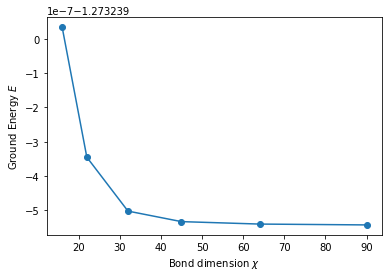

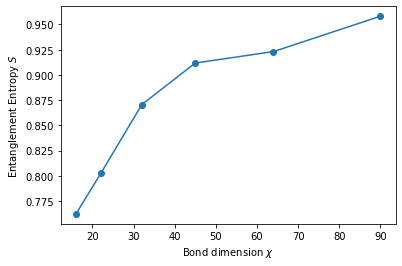

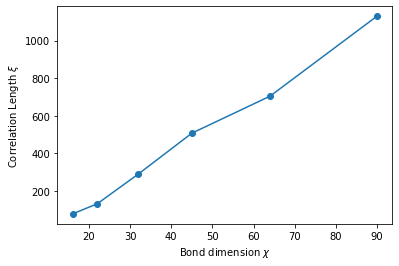

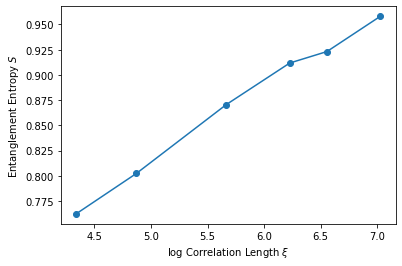

In [25]:
plot_results(data)

In [26]:
chi_list = data['chi_list']
energy_list = data['energy_list']
entropy_list = data['entropy_list']
correlation_list = data['correlation_list']

log_xi = np.log(correlation_list)
s = entropy_list

def func(log_xi, c, a):
    return (c / 6) * log_xi + a
fitParams, fitCovariances = curve_fit(func, log_xi, s)

print(fitParams)

[0.43898571 0.44840178]


In [23]:
def run_TFI(
    J=1.,
    g=1.,
    L=2,
    chi_list=[int(2**i) for i in np.arange(4, 7, 0.5)],
    calc_correlation=True,
):

    model_params = dict(
        L=L, 
        J=J, 
        g=g, 
        bc_MPS='infinite', 
        conserve='best',
        verbose=0,
        )
    prod_state = ["up"] * model_params['L']
    M = TFIChain(model_params)
    psi = MPS.from_product_state(
        M.lat.mps_sites(), 
        prod_state, 
        bc=M.lat.bc_MPS,
    )

    dmrg_params = {
        'start_env': 10,
#         'mixer': False,  # setting this to True helps to escape local minima
        'mixer': True,
        'mixer_params': {
            'amplitude': 1.e-5,
            'decay': 1.2,
            'disable_after': 30
        },
        'trunc_params': {
            'chi_max': 4,
            'svd_min': 1.e-10,
        },
        'max_E_err': 1.e-10,
        'max_S_err': 1.e-8,
        'max_sweeps': 1000,
        'verbose': 1.,
    }
    
    
#     eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    
    # we will return this data dictionary in the end, for the further investigation
    data = dict(
        chi_list=[],
        energy_list=[], 
        entropy_list=[], 
        correlation_list=[],
    )
    
#     chi_list = np.arange(4, 129)
    data['chi_list'] = chi_list
    for chi in chi_list:
        
        print("\n")
        print("=" * 80)
        print("="*30 + "START" + "="*30)
        print("=" * 80)
        print("Chi = ", chi, '\n')
        
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
        eng.reset_stats()
        eng.trunc_params['chi_max'] = chi
        info = eng.run()
#         print("INFO: \n", info)

        print("Before the canonicalization:")
        print("Bond dim = ", psi.chi)
        
        print("Canonicalizing...")
        psi_before = psi.copy()
        psi.canonical_form()
        ov = psi.overlap(psi_before, charge_sector=0)
        print("The norm is: ",psi.norm)
        print("The overlap is: ", ov)
        print("After the canonicalization:")
        print("Bond dim = ", psi.chi)
        
        print("Computing properties")
        
        energy=info[0]
        data['energy_list'].append(energy)
        
        entropy = np.mean(psi.entanglement_entropy())
        data['entropy_list'].append(entropy)
        
        if calc_correlation:
            correlation = psi.correlation_length()
            data['correlation_list'].append(correlation)
        
        print("Optimizing")
        tenpy.tools.optimization.optimize(3)
        print("Loop for chi=%d done." % chi)
        print("=" * 80)
        print("="*30 + " END " + "="*30)
        print("=" * 80)
        pass
        
    return data


In [8]:
data2=run_TFI()



==============================START==============================
Chi =  16 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-10 for config TwoSiteDMRGEngine
Reading 'max_S_err'=1e-08 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2732294404668316, S = nan, norm_err = 9.1e-04
Current memory usage 127.2 MB, time elapsed: 1.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.2977e-10, max_E_trunc = 2.0407e-09
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2732370232930563, S = nan, norm_err = 5.4e-04
Current memory usage 127.2 MB, 

Updating environment
.....
sweep 200, age = 2480
Energy = -1.2732389660362742, S = 0.7624530778535742, norm_err = 2.0e-05
Current memory usage 127.7 MB, time elapsed: 15.6 s
Delta E = -2.4215e-12, Delta S = 2.4164e-05 (per sweep)
max_trunc_err = 3.3686e-08, max_E_trunc = 2.1003e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 210, age = 2600
Energy = -1.2732389659628325, S = 0.7625091810696709, norm_err = 1.8e-05
Current memory usage 127.7 MB, time elapsed: 16.1 s
Delta E = 7.3442e-12, Delta S = 5.6103e-06 (per sweep)
max_trunc_err = 3.3785e-08, max_E_trunc = 2.1065e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 220, age = 2720
Energy = -1.2732389659740306, S = 0.7626773690847906, norm_err = 1.0e-05
Current memory usage 127.7 MB, time elapsed: 16.6 s
Delta E = -1.1198e-12, Delta S = 1.6819e-05 (per sweep)
max_trunc_err = 3.3830e-08, max_E_trunc = 2.1094e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 230, age = 2840
Energy = -1.2

Updating environment
.....
sweep 410, age = 5000
Energy = -1.2732389653886003, S = 0.7628603176122406, norm_err = 5.5e-06
Current memory usage 128.3 MB, time elapsed: 26.2 s
Delta E = 1.2494e-11, Delta S = -1.9697e-05 (per sweep)
max_trunc_err = 3.4140e-08, max_E_trunc = 2.1286e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 420, age = 5120
Energy = -1.2732389654540839, S = 0.7630674798417979, norm_err = 1.4e-05
Current memory usage 128.3 MB, time elapsed: 26.7 s
Delta E = -6.5484e-12, Delta S = 2.0716e-05 (per sweep)
max_trunc_err = 3.4066e-08, max_E_trunc = 2.1242e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 430, age = 5240
Energy = -1.2732389653168639, S = 0.7628497200141784, norm_err = 5.8e-06
Current memory usage 128.3 MB, time elapsed: 27.2 s
Delta E = 1.3722e-11, Delta S = -2.1776e-05 (per sweep)
max_trunc_err = 3.4148e-08, max_E_trunc = 2.1290e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 440, age = 5360
Energy = -1.

Updating environment
.....
sweep 620, age = 7520
Energy = -1.2732389645580042, S = 0.7639225682183045, norm_err = 5.6e-05
Current memory usage 128.8 MB, time elapsed: 42.3 s
Delta E = -2.8899e-11, Delta S = -1.9043e-05 (per sweep)
max_trunc_err = 3.4179e-08, max_E_trunc = 2.1287e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 630, age = 7640
Energy = -1.2732389649086144, S = 0.7637657705599477, norm_err = 4.7e-05
Current memory usage 128.8 MB, time elapsed: 42.9 s
Delta E = -3.5061e-11, Delta S = -1.5680e-05 (per sweep)
max_trunc_err = 3.4130e-08, max_E_trunc = 2.1261e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 640, age = 7760
Energy = -1.2732389651996527, S = 0.7635870207325623, norm_err = 4.0e-05
Current memory usage 128.8 MB, time elapsed: 43.4 s
Delta E = -2.9104e-11, Delta S = -1.7875e-05 (per sweep)
max_trunc_err = 3.4105e-08, max_E_trunc = 2.1251e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 650, age = 7880
Energy = 

Updating environment
.....
sweep 830, age = 10040
Energy = -1.2732389657394378, S = 0.7629963169530760, norm_err = 8.2e-06
Current memory usage 129.3 MB, time elapsed: 53.1 s
Delta E = -1.8872e-12, Delta S = 4.6842e-06 (per sweep)
max_trunc_err = 3.4078e-08, max_E_trunc = 2.1248e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 840, age = 10160
Energy = -1.2732389657121530, S = 0.7629465449052946, norm_err = 5.8e-06
Current memory usage 129.3 MB, time elapsed: 53.6 s
Delta E = 2.7285e-12, Delta S = -4.9772e-06 (per sweep)
max_trunc_err = 3.4095e-08, max_E_trunc = 2.1259e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 850, age = 10280
Energy = -1.2732389657394378, S = 0.7629988592534822, norm_err = 8.4e-06
Current memory usage 129.3 MB, time elapsed: 54.1 s
Delta E = -2.7285e-12, Delta S = 5.2314e-06 (per sweep)
max_trunc_err = 3.4078e-08, max_E_trunc = 2.1249e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 860, age = 10400
Energy =

..........
Reading 'P_tol_to_trunc'=0.05 for config TwoSiteDMRGEngine
Reading 'P_tol_min'=1e-30 for config TwoSiteDMRGEngine
Reading 'P_tol_max'=0.0001 for config TwoSiteDMRGEngine
Reading 'E_tol_to_trunc'=None for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'min_sweeps'=15 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-10 for config TwoSiteDMRGEngine
Reading 'max_S_err'=1e-08 for config TwoSiteDMRGEngine
Reading 'max_hours'=8760 for config TwoSiteDMRGEngine
Reading 'norm_tol'=1e-05 for config TwoSiteDMRGEngine
Reading 'update_env'=5 for config TwoSiteDMRGEngine
Reading 'norm_tol_iter'=5 for config TwoSiteDMRGEngine
Reading 'diag_method'='default' for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Reading 'max_N_for_ED'=400 for config TwoSiteDMRGEngine
Updating envi

Updating environment
.....
sweep 200, age = 2480
Energy = -1.2732393304356719, S = 0.8006340355557535, norm_err = 5.3e-05
Current memory usage 130.7 MB, time elapsed: 20.2 s
Delta E = -5.2999e-10, Delta S = 3.9306e-05 (per sweep)
max_trunc_err = 1.1445e-08, max_E_trunc = 7.7231e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 210, age = 2600
Energy = -1.2732393419280470, S = 0.8009385168932635, norm_err = 5.4e-05
Current memory usage 130.7 MB, time elapsed: 21.1 s
Delta E = -1.1492e-09, Delta S = 3.0448e-05 (per sweep)
max_trunc_err = 1.1528e-08, max_E_trunc = 7.7718e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 220, age = 2720
Energy = -1.2732393429769218, S = 0.8011728220195866, norm_err = 3.6e-05
Current memory usage 130.7 MB, time elapsed: 21.9 s
Delta E = -1.0489e-10, Delta S = 2.3431e-05 (per sweep)
max_trunc_err = 1.1294e-08, max_E_trunc = 7.6437e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 230, age = 2840
Energy = -1.

Updating environment
.....
sweep 410, age = 5000
Energy = -1.2732393171630747, S = 0.8021468738744622, norm_err = 5.8e-05
Current memory usage 130.7 MB, time elapsed: 39.1 s
Delta E = 2.4247e-09, Delta S = -6.5605e-05 (per sweep)
max_trunc_err = 1.1620e-08, max_E_trunc = 7.8371e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 420, age = 5120
Energy = -1.2732393140829572, S = 0.8018608779637482, norm_err = 6.3e-05
Current memory usage 130.7 MB, time elapsed: 40.0 s
Delta E = 3.0801e-10, Delta S = -2.8600e-05 (per sweep)
max_trunc_err = 1.1553e-08, max_E_trunc = 7.7931e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 430, age = 5240
Energy = -1.2732393402447997, S = 0.8018933737489609, norm_err = 5.5e-05
Current memory usage 130.7 MB, time elapsed: 41.0 s
Delta E = -2.6162e-09, Delta S = 3.2496e-06 (per sweep)
max_trunc_err = 1.1643e-08, max_E_trunc = 7.8523e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 440, age = 5360
Energy = -1.

Updating environment
.....
sweep 620, age = 7520
Energy = -1.2732393411608882, S = 0.8019830854927396, norm_err = 3.8e-05
Current memory usage 130.7 MB, time elapsed: 56.3 s
Delta E = -1.8154e-09, Delta S = 7.0191e-06 (per sweep)
max_trunc_err = 1.1637e-08, max_E_trunc = 7.8482e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 630, age = 7640
Energy = -1.2732393249980305, S = 0.8020269805871407, norm_err = 5.5e-05
Current memory usage 130.7 MB, time elapsed: 57.2 s
Delta E = 1.6163e-09, Delta S = 4.3895e-06 (per sweep)
max_trunc_err = 1.1663e-08, max_E_trunc = 7.8651e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 640, age = 7760
Energy = -1.2732393430649154, S = 0.8017916829790472, norm_err = 4.2e-05
Current memory usage 130.7 MB, time elapsed: 58.2 s
Delta E = -1.8067e-09, Delta S = -2.3530e-05 (per sweep)
max_trunc_err = 1.1579e-08, max_E_trunc = 7.8080e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 650, age = 7880
Energy = -1.

Updating environment
.....
sweep 830, age = 10040
Energy = -1.2732393429830609, S = 0.8017972437058973, norm_err = 4.2e-05
Current memory usage 130.7 MB, time elapsed: 76.6 s
Delta E = -7.9415e-10, Delta S = -1.4267e-05 (per sweep)
max_trunc_err = 1.1604e-08, max_E_trunc = 7.8242e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 840, age = 10160
Energy = -1.2732393242602029, S = 0.8018642150914980, norm_err = 5.5e-05
Current memory usage 130.7 MB, time elapsed: 77.6 s
Delta E = 1.8723e-09, Delta S = 6.6971e-06 (per sweep)
max_trunc_err = 1.1617e-08, max_E_trunc = 7.8348e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 850, age = 10280
Energy = -1.2732393430096636, S = 0.8020216574043457, norm_err = 4.1e-05
Current memory usage 130.7 MB, time elapsed: 78.6 s
Delta E = -1.8749e-09, Delta S = 1.5744e-05 (per sweep)
max_trunc_err = 1.1675e-08, max_E_trunc = 7.8697e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 860, age = 10400
Energy =

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.....
Updating environment
.....
Updating environment
.....
DMRG finished after 1000 sweeps.
total size = 12280, maximum chi = 22
Before the canonicalization:
Bond dim =  [22, 22]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000029124085+0j)
After the canonicalization:
Bond dim =  [22, 22]
Computing properties
Optimizing
Loop for chi=22 done.
============================== END ==============================


==============================START==============================
Chi =  32 

Reading 'combine'=False for config TwoSiteDMRGEngine
Subconfig 'lanczos_params'=Config(<12 options>, 'lanczos_params') for config TwoSiteDMRGEngine
Subconfig 'trunc_params'=Config(<6 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'init_env_data'={} for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[] for config TwoSiteDMRGEngine
Reading 'sweep_0'=0 for config TwoSiteDMRGEngine
Reading 'chi_list'=None for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 f

Updating environment
.....
sweep 160, age = 2000
Energy = -1.2732394964527884, S = 0.8391763325274886, norm_err = 4.5e-05
Current memory usage 130.7 MB, time elapsed: 20.6 s
Delta E = -1.1877e-10, Delta S = 2.5864e-04 (per sweep)
max_trunc_err = 1.5715e-09, max_E_trunc = 1.0722e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 170, age = 2120
Energy = -1.2732394955522182, S = 0.8420335664510328, norm_err = 5.5e-05
Current memory usage 130.7 MB, time elapsed: 21.6 s
Delta E = 9.0057e-11, Delta S = 2.8572e-04 (per sweep)
max_trunc_err = 1.6594e-09, max_E_trunc = 1.1271e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 180, age = 2240
Energy = -1.2732394960391389, S = 0.8444918574474984, norm_err = 4.8e-05
Current memory usage 130.7 MB, time elapsed: 22.6 s
Delta E = -4.8692e-11, Delta S = 2.4583e-04 (per sweep)
max_trunc_err = 1.7024e-09, max_E_trunc = 1.1548e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 190, age = 2360
Energy = -1.2

Updating environment
.....
sweep 370, age = 4520
Energy = -1.2732395008780486, S = 0.8646851750355027, norm_err = 1.4e-05
Current memory usage 130.7 MB, time elapsed: 41.5 s
Delta E = -3.9324e-11, Delta S = 5.8840e-05 (per sweep)
max_trunc_err = 2.2104e-09, max_E_trunc = 1.4814e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 380, age = 4640
Energy = -1.2732395009103357, S = 0.8651467961282304, norm_err = 1.4e-05
Current memory usage 130.7 MB, time elapsed: 42.5 s
Delta E = -3.2287e-12, Delta S = 4.6162e-05 (per sweep)
max_trunc_err = 2.2200e-09, max_E_trunc = 1.4875e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 390, age = 4760
Energy = -1.2732395013400719, S = 0.8656180433010747, norm_err = 1.6e-05
Current memory usage 130.7 MB, time elapsed: 43.5 s
Delta E = -4.2974e-11, Delta S = 4.7125e-05 (per sweep)
max_trunc_err = 2.2237e-09, max_E_trunc = 1.4882e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 400, age = 4880
Energy = -1.

Updating environment
.....
sweep 580, age = 7040
Energy = -1.2732395009422817, S = 0.8697969175482521, norm_err = 2.3e-05
Current memory usage 130.7 MB, time elapsed: 60.8 s
Delta E = -3.3265e-11, Delta S = -9.3843e-09 (per sweep)
max_trunc_err = 2.3325e-09, max_E_trunc = 1.5572e-08
MPS bond dimensions: [32, 32]
norm_tol=1.00e-05 not reached, norm_err=2.32e-05
Updating environment
.....
Updating environment
.....


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Updating environment
.....
Updating environment
.....
DMRG finished after 580 sweeps.
total size = 7200, maximum chi = 32
Before the canonicalization:
Bond dim =  [32, 32]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000152923156+0j)
After the canonicalization:
Bond dim =  [32, 32]
Computing properties
Optimizing
Loop for chi=32 done.
============================== END ==============================


==============================START==============================
Chi =  45 

Reading 'combine'=False for config TwoSiteDMRGEngine
Subconfig 'lanczos_params'=Config(<12 options>, 'lanczos_params') for config TwoSiteDMRGEngine
Subconfig 'trunc_params'=Config(<6 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'init_env_data'={} for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[] for config TwoSiteDMRGEngine
Reading 'sweep_0'=0 for config TwoSiteDMRGEngine
Reading 'chi_list'=None for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for confi

Updating environment
.....
sweep 160, age = 2000
Energy = -1.2732395108353671, S = 0.8357868597555833, norm_err = 6.5e-05
Current memory usage 130.7 MB, time elapsed: 20.0 s
Delta E = -3.6577e-10, Delta S = 4.6197e-04 (per sweep)
max_trunc_err = 1.6131e-10, max_E_trunc = 1.0032e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 170, age = 2120
Energy = -1.2732395134891021, S = 0.8401072705683137, norm_err = 6.3e-05
Current memory usage 130.7 MB, time elapsed: 21.1 s
Delta E = -2.6537e-10, Delta S = 4.3204e-04 (per sweep)
max_trunc_err = 1.8081e-10, max_E_trunc = 1.1196e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 180, age = 2240
Energy = -1.2732395160273882, S = 0.8441537424837919, norm_err = 6.0e-05
Current memory usage 130.7 MB, time elapsed: 22.1 s
Delta E = -2.5383e-10, Delta S = 4.0465e-04 (per sweep)
max_trunc_err = 1.9689e-10, max_E_trunc = 1.2205e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 190, age = 2360
Energy = -1.

Updating environment
.....
sweep 370, age = 4520
Energy = -1.2732395311252276, S = 0.8893465635450428, norm_err = 4.7e-06
Current memory usage 130.8 MB, time elapsed: 41.0 s
Delta E = -5.1065e-10, Delta S = 1.3462e-05 (per sweep)
max_trunc_err = 4.3394e-10, max_E_trunc = 2.6585e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 380, age = 4640
Energy = -1.2732395313173583, S = 0.8915002122085018, norm_err = 4.8e-05
Current memory usage 130.8 MB, time elapsed: 41.5 s
Delta E = -1.9213e-11, Delta S = 2.1536e-04 (per sweep)
max_trunc_err = 4.3958e-10, max_E_trunc = 2.6939e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 390, age = 4760
Energy = -1.2732395315246094, S = 0.8925017392271289, norm_err = 4.8e-06
Current memory usage 130.8 MB, time elapsed: 42.1 s
Delta E = -2.0725e-11, Delta S = 1.0015e-04 (per sweep)
max_trunc_err = 4.5056e-10, max_E_trunc = 2.7621e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 400, age = 4880
Energy = -1.

Updating environment
.....
sweep 580, age = 7040
Energy = -1.2732395325606376, S = 0.9102363848305317, norm_err = 5.0e-05
Current memory usage 130.8 MB, time elapsed: 55.8 s
Delta E = 1.6712e-11, Delta S = 2.3169e-04 (per sweep)
max_trunc_err = 5.6728e-10, max_E_trunc = 3.4506e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 590, age = 7160
Energy = -1.2732395327996073, S = 0.9097721407510214, norm_err = 2.6e-05
Current memory usage 130.8 MB, time elapsed: 56.9 s
Delta E = -2.3897e-11, Delta S = -4.6424e-05 (per sweep)
max_trunc_err = 5.6589e-10, max_E_trunc = 3.4561e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 600, age = 7280
Energy = -1.2732395328100665, S = 0.9091783316574553, norm_err = 8.3e-06
Current memory usage 130.8 MB, time elapsed: 57.5 s
Delta E = -1.0459e-12, Delta S = -5.9381e-05 (per sweep)
max_trunc_err = 5.7113e-10, max_E_trunc = 3.4725e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 610, age = 7400
Energy = -1

Updating environment
.....
sweep 790, age = 9560
Energy = -1.2732395327500399, S = 0.9176121869947627, norm_err = 1.7e-05
Current memory usage 130.8 MB, time elapsed: 76.4 s
Delta E = 6.3596e-11, Delta S = 6.4657e-05 (per sweep)
max_trunc_err = 5.6543e-10, max_E_trunc = 3.4688e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 800, age = 9680
Energy = -1.2732395329294377, S = 0.9174225997226206, norm_err = 1.5e-05
Current memory usage 130.8 MB, time elapsed: 77.5 s
Delta E = -1.7940e-11, Delta S = -1.8959e-05 (per sweep)
max_trunc_err = 5.6601e-10, max_E_trunc = 3.4797e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 810, age = 9800
Energy = -1.2732395325760990, S = 0.9184588672072549, norm_err = 2.2e-05
Current memory usage 130.8 MB, time elapsed: 78.5 s
Delta E = 3.5334e-11, Delta S = 1.0363e-04 (per sweep)
max_trunc_err = 5.6870e-10, max_E_trunc = 3.4979e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 820, age = 9920
Energy = -1.2

Updating environment
.....
sweep 1000, age = 12080
Energy = -1.2732395334248849, S = 0.9227544714315585, norm_err = 1.4e-05
Current memory usage 130.8 MB, time elapsed: 95.5 s
Delta E = 2.4784e-12, Delta S = 7.7575e-05 (per sweep)
max_trunc_err = 5.8943e-10, max_E_trunc = 3.6453e-09
MPS bond dimensions: [45, 45]
norm_tol=1.00e-05 not reached, norm_err=1.39e-05
Updating environment
.....
Updating environment
....

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
.....
DMRG finished after 1000 sweeps.
total size = 12200, maximum chi = 45
Before the canonicalization:
Bond dim =  [45, 45]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000103408413+0j)
After the canonicalization:
Bond dim =  [45, 45]
Computing properties
Optimizing
Loop for chi=45 done.
============================== END ==============================


==============================START==============================
Chi =  64 

Reading 'combine'=False for config TwoSiteDMRGEngine
Subconfig 'lanczos_params'=Config(<12 options>, 'lanczos_params') for config TwoSiteDMRGEngine
Subconfig 'trunc_params'=Config(<6 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'init_env_data'={} for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[] for config TwoSiteDMRGEngine
Reading 'sweep_0'=0 for config TwoSiteDMRGEngine
Reading 'chi_list'=None for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Upda

Updating environment
.....
sweep 160, age = 2000
Energy = -1.2732395133027126, S = 0.8369059085837545, norm_err = 7.0e-05
Current memory usage 131.9 MB, time elapsed: 27.7 s
Delta E = -3.9288e-10, Delta S = 4.9250e-04 (per sweep)
max_trunc_err = 1.2962e-11, max_E_trunc = 8.6402e-11
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 170, age = 2120
Energy = -1.2732395165935486, S = 0.8416430339516268, norm_err = 6.9e-05
Current memory usage 131.9 MB, time elapsed: 28.9 s
Delta E = -3.2908e-10, Delta S = 4.7371e-04 (per sweep)
max_trunc_err = 1.4645e-11, max_E_trunc = 9.5952e-11
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 180, age = 2240
Energy = -1.2732395192463173, S = 0.8460734725438855, norm_err = 6.8e-05
Current memory usage 131.9 MB, time elapsed: 30.4 s
Delta E = -2.6528e-10, Delta S = 4.4304e-04 (per sweep)
max_trunc_err = 1.6693e-11, max_E_trunc = 1.1278e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 190, age = 2360
Energy = -1.

Updating environment
.....
sweep 370, age = 4520
Energy = -1.2732395372952396, S = 0.9005974607555516, norm_err = 2.8e-05
Current memory usage 131.9 MB, time elapsed: 58.8 s
Delta E = -2.7308e-11, Delta S = 2.0017e-04 (per sweep)
max_trunc_err = 5.2336e-11, max_E_trunc = 3.4834e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 380, age = 4640
Energy = -1.2732395376225440, S = 0.9026014152983658, norm_err = 2.9e-05
Current memory usage 131.9 MB, time elapsed: 59.8 s
Delta E = -3.2730e-11, Delta S = 2.0040e-04 (per sweep)
max_trunc_err = 5.4559e-11, max_E_trunc = 3.6289e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 390, age = 4760
Energy = -1.2732395378844785, S = 0.9044091686298128, norm_err = 2.6e-05
Current memory usage 131.9 MB, time elapsed: 60.6 s
Delta E = -2.6193e-11, Delta S = 1.8078e-04 (per sweep)
max_trunc_err = 5.4752e-11, max_E_trunc = 3.7016e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 400, age = 4880
Energy = -1.

Updating environment
.....
sweep 580, age = 7040
Energy = -1.2732395401958456, S = 0.9322114854282209, norm_err = 5.9e-05
Current memory usage 131.9 MB, time elapsed: 82.8 s
Delta E = -5.6434e-11, Delta S = 4.3523e-05 (per sweep)
max_trunc_err = 8.8703e-11, max_E_trunc = 5.9299e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 590, age = 7160
Energy = -1.2732395403706960, S = 0.9327019918236229, norm_err = 4.4e-05
Current memory usage 131.9 MB, time elapsed: 84.6 s
Delta E = -1.7485e-11, Delta S = 4.9051e-05 (per sweep)
max_trunc_err = 9.0779e-11, max_E_trunc = 6.1118e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 600, age = 7280
Energy = -1.2732395405078023, S = 0.9329396412404531, norm_err = 6.7e-06
Current memory usage 131.9 MB, time elapsed: 86.2 s
Delta E = -1.3711e-11, Delta S = 2.3765e-05 (per sweep)
max_trunc_err = 8.9516e-11, max_E_trunc = 6.0754e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 610, age = 7400
Energy = -1.

Updating environment
.....
sweep 790, age = 9560
Energy = -1.2732395410193931, S = 0.9484676608979103, norm_err = 1.4e-05
Current memory usage 131.9 MB, time elapsed: 110.5 s
Delta E = -1.6257e-11, Delta S = -3.8799e-05 (per sweep)
max_trunc_err = 1.1471e-10, max_E_trunc = 7.8398e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 800, age = 9680
Energy = -1.2732395409020683, S = 0.9499348140017656, norm_err = 1.7e-05
Current memory usage 132.2 MB, time elapsed: 112.3 s
Delta E = 1.1732e-11, Delta S = 1.4672e-04 (per sweep)
max_trunc_err = 1.1545e-10, max_E_trunc = 7.6761e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 810, age = 9800
Energy = -1.2732395411576363, S = 0.9510760582941256, norm_err = 4.0e-05
Current memory usage 132.2 MB, time elapsed: 113.5 s
Delta E = -2.5557e-11, Delta S = 1.1412e-04 (per sweep)
max_trunc_err = 1.1711e-10, max_E_trunc = 7.7853e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 820, age = 9920
Energy = 

Updating environment
.....
sweep 1000, age = 12080
Energy = -1.2732395414091116, S = 0.9601734358804339, norm_err = 1.6e-05
Current memory usage 132.2 MB, time elapsed: 143.4 s
Delta E = -1.2483e-11, Delta S = 1.3342e-04 (per sweep)
max_trunc_err = 1.3223e-10, max_E_trunc = 8.9130e-10
MPS bond dimensions: [64, 64]
norm_tol=1.00e-05 not reached, norm_err=1.60e-05
Updating environment
.....
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.50e-05
Call psi.canonical_form()
DMRG finished after 1000 sweeps.
total size = 12280, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000036+0j)
After the canonicalization:
Bond dim =  [64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================


==============================START==============================
Chi =  90 

Reading 'combine'=False for config TwoSiteDMRGEngine
Subconfig 'lanczos_params'=Config(<12 options>, 'lanczos_params') for config TwoSiteDMRGEngine
Subconfig 'trunc_params'=Config(<6 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'init_env_data'={} for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[] for config TwoSiteDMRGEngine

.....
sweep 150, age = 1880
Energy = -1.2732395044466216, S = 0.8264169893429387, norm_err = 8.4e-05
Current memory usage 134.4 MB, time elapsed: 34.1 s
Delta E = -5.9345e-10, Delta S = 5.7285e-04 (per sweep)
max_trunc_err = 5.7258e-13, max_E_trunc = 6.8212e-12
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 160, age = 2000
Energy = -1.2732395093044033, S = 0.8317640873967982, norm_err = 7.8e-05
Current memory usage 134.4 MB, time elapsed: 36.0 s
Delta E = -4.8578e-10, Delta S = 5.3471e-04 (per sweep)
max_trunc_err = 6.9257e-13, max_E_trunc = 8.1855e-12
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 170, age = 2120
Energy = -1.2732395133323280, S = 0.8368025924273085, norm_err = 7.4e-05
Current memory usage 134.4 MB, time elapsed: 37.4 s
Delta E = -4.0279e-10, Delta S = 5.0385e-04 (per sweep)
max_trunc_err = 8.0304e-13, max_E_trunc = 9.5497e-12
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 180, age = 2240
Energy = -1.2732395167078039, S =

Updating environment
.....
sweep 360, age = 4400
Energy = -1.2732395375813894, S = 0.8987775592265856, norm_err = 3.4e-05
Current memory usage 134.4 MB, time elapsed: 69.5 s
Delta E = -4.1598e-11, Delta S = 2.2963e-04 (per sweep)
max_trunc_err = 4.5528e-12, max_E_trunc = 3.4561e-11
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 370, age = 4520
Energy = -1.2732395379464378, S = 0.9010091513790472, norm_err = 3.3e-05
Current memory usage 134.4 MB, time elapsed: 71.1 s
Delta E = -3.6505e-11, Delta S = 2.2316e-04 (per sweep)
max_trunc_err = 4.8205e-12, max_E_trunc = 4.0927e-11
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 380, age = 4640
Energy = -1.2732395382869299, S = 0.9031324752655198, norm_err = 3.1e-05
Current memory usage 134.4 MB, time elapsed: 72.8 s
Delta E = -3.4049e-11, Delta S = 2.1233e-04 (per sweep)
max_trunc_err = 5.0767e-12, max_E_trunc = 4.4565e-11
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 390, age = 4760
Energy = -1.

Updating environment
.....
sweep 570, age = 6920
Energy = -1.2732395416744566, S = 0.9357249591648238, norm_err = 2.1e-05
Current memory usage 134.4 MB, time elapsed: 105.1 s
Delta E = -8.7994e-12, Delta S = 1.4044e-04 (per sweep)
max_trunc_err = 1.0074e-11, max_E_trunc = 8.1855e-11
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 580, age = 7040
Energy = -1.2732395417692715, S = 0.9371029829681805, norm_err = 2.1e-05
Current memory usage 134.4 MB, time elapsed: 106.9 s
Delta E = -9.4815e-12, Delta S = 1.3780e-04 (per sweep)
max_trunc_err = 1.0362e-11, max_E_trunc = 8.0036e-11
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 590, age = 7160
Energy = -1.2732395418665874, S = 0.9385045533635032, norm_err = 2.3e-05
Current memory usage 134.4 MB, time elapsed: 108.5 s
Delta E = -9.7316e-12, Delta S = 1.4016e-04 (per sweep)
max_trunc_err = 1.0397e-11, max_E_trunc = 7.2760e-11
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 600, age = 7280
Energy = 

Updating environment
.....
sweep 780, age = 9440
Energy = -1.2732395428681684, S = 0.9602619333281002, norm_err = 3.7e-05
Current memory usage 134.6 MB, time elapsed: 148.4 s
Delta E = -2.5011e-12, Delta S = 1.8853e-04 (per sweep)
max_trunc_err = 1.5792e-11, max_E_trunc = 1.0368e-10
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 790, age = 9560
Energy = -1.2732395429070493, S = 0.9603941759760484, norm_err = 8.3e-06
Current memory usage 134.6 MB, time elapsed: 150.9 s
Delta E = -3.8881e-12, Delta S = 1.3224e-05 (per sweep)
max_trunc_err = 1.6086e-11, max_E_trunc = 1.1096e-10
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 800, age = 9680
Energy = -1.2732395429038661, S = 0.9620616388096390, norm_err = 3.4e-05
Current memory usage 134.6 MB, time elapsed: 153.1 s
Delta E = 3.1832e-13, Delta S = 1.6675e-04 (per sweep)
max_trunc_err = 1.6259e-11, max_E_trunc = 1.1278e-10
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 810, age = 9800
Energy = -

Updating environment
.....
sweep 990, age = 11960
Energy = -1.2732395432549310, S = 0.9756777498831182, norm_err = 4.2e-05
Current memory usage 134.7 MB, time elapsed: 195.1 s
Delta E = 4.9795e-12, Delta S = -1.0217e-04 (per sweep)
max_trunc_err = 2.0802e-11, max_E_trunc = 1.3279e-10
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 1000, age = 12080
Energy = -1.2732395432401518, S = 0.9784957283112025, norm_err = 5.6e-05
Current memory usage 134.7 MB, time elapsed: 197.5 s
Delta E = 1.4779e-12, Delta S = 2.8180e-04 (per sweep)
max_trunc_err = 2.1159e-11, max_E_trunc = 1.4916e-10
MPS bond dimensions: [90, 90]
norm_tol=1.00e-05 not reached, norm_err=5.58e-05
Updating environment
.....
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 5.77e-05
Call psi.canonical_form()
DMRG finished after 1000 sweeps.
total size = 12280, maximum chi = 90
Before the canonicalization:
Bond dim =  [90, 90]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000047+0j)
After the canonicalization:
Bond dim =  [90, 90]
Computing properties
Optimizing
Loop for chi=90 done.
============================== END ==============================


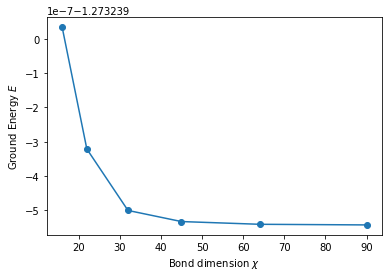

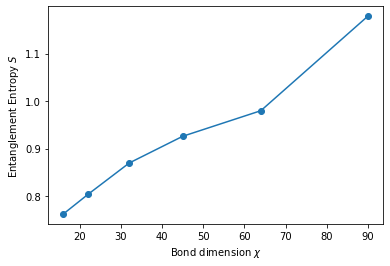

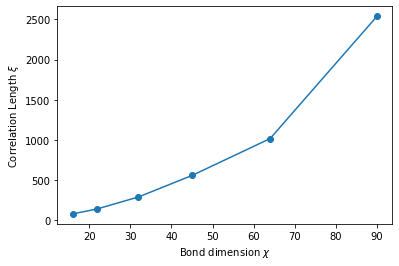

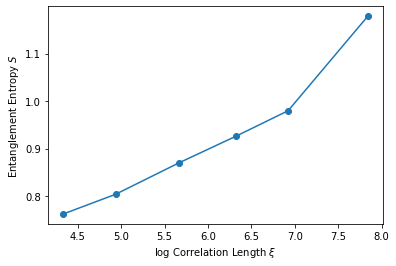

In [9]:
plot_results(data2)

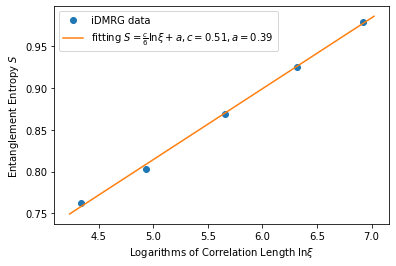

[0.50939689 0.38979353]


In [65]:
chi_list = data2['chi_list']
energy_list = data2['energy_list']
entropy_list = data2['entropy_list']
correlation_list = data2['correlation_list']

log_xi = np.log(correlation_list)[0:-1]
s = entropy_list[0:-1]

def func(log_xi, c, a):
    return (c / 6) * log_xi + a
fitParams, fitCovariances = curve_fit(func, log_xi, s)

plt.plot(log_xi, s, 'o', label='iDMRG data')

logxilist=np.linspace(log_xi[0]-0.1, log_xi[-1]+0.1, 1000)
slist = [func(lnxi, fitParams[0], fitParams[1]) for lnxi in logxilist]
plt.plot(logxilist, slist, '-', label=r'fitting $S = \frac{c}{6}\ln\xi + a, c=%.2f, a=%.2f$' % (fitParams[0], fitParams[1]))

plt.xlabel(r'Logarithms of Correlation Length $\ln\xi$')
plt.ylabel(r'Entanglement Entropy $S$')

plt.legend()

plt.show()
print(fitParams)

## Gapped



==============================START==============================
Chi =  16 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-10 for config TwoSiteDMRGEngine
Reading 'max_S_err'=1e-08 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0313740257056097, S = nan, norm_err = 1.6e-15
Current memory usage 179.4 MB, time elapsed: 1.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2023e-21, max_E_trunc = 5.6843e-14
MPS bond dimensions: [7, 8]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0313740257057162, S = nan, norm_err = 1.9e-15
Current memory usage 179.4 MB, ti

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


......
Reading 'P_tol_to_trunc'=0.05 for config TwoSiteDMRGEngine
Reading 'P_tol_min'=1e-30 for config TwoSiteDMRGEngine
Reading 'P_tol_max'=0.0001 for config TwoSiteDMRGEngine
Reading 'E_tol_to_trunc'=None for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'min_sweeps'=15 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-10 for config TwoSiteDMRGEngine
Reading 'max_S_err'=1e-08 for config TwoSiteDMRGEngine
Reading 'max_hours'=8760 for config TwoSiteDMRGEngine
Reading 'norm_tol'=1e-05 for config TwoSiteDMRGEngine
Reading 'update_env'=5 for config TwoSiteDMRGEngine
Reading 'norm_tol_iter'=5 for config TwoSiteDMRGEngine
Reading 'diag_method'='default' for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Reading 'max_N_for_ED'=400 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.....
Reading 'P_tol_to_trunc'=0.05 for config TwoSiteDMRGEngine
Reading 'P_tol_min'=1e-30 for config TwoSiteDMRGEngine
Reading 'P_tol_max'=0.0001 for config TwoSiteDMRGEngine
Reading 'E_tol_to_trunc'=None for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'min_sweeps'=15 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-10 for config TwoSiteDMRGEngine
Reading 'max_S_err'=1e-08 for config TwoSiteDMRGEngine
Reading 'max_hours'=8760 for config TwoSiteDMRGEngine
Reading 'norm_tol'=1e-05 for config TwoSiteDMRGEngine
Reading 'update_env'=5 for config TwoSiteDMRGEngine
Reading 'norm_tol_iter'=5 for config TwoSiteDMRGEngine
Reading 'diag_method'='default' for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Reading 'max_N_for_ED'=400 for config TwoSiteDMRGEngine
Updating environme

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.....
Reading 'P_tol_to_trunc'=0.05 for config TwoSiteDMRGEngine
Reading 'P_tol_min'=1e-30 for config TwoSiteDMRGEngine
Reading 'P_tol_max'=0.0001 for config TwoSiteDMRGEngine
Reading 'E_tol_to_trunc'=None for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'min_sweeps'=15 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-10 for config TwoSiteDMRGEngine
Reading 'max_S_err'=1e-08 for config TwoSiteDMRGEngine
Reading 'max_hours'=8760 for config TwoSiteDMRGEngine
Reading 'norm_tol'=1e-05 for config TwoSiteDMRGEngine
Reading 'update_env'=5 for config TwoSiteDMRGEngine
Reading 'norm_tol_iter'=5 for config TwoSiteDMRGEngine
Reading 'diag_method'='default' for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Reading 'max_N_for_ED'=400 for config TwoSiteDMRGEngine
Updating environme

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.....
Reading 'P_tol_to_trunc'=0.05 for config TwoSiteDMRGEngine
Reading 'P_tol_min'=1e-30 for config TwoSiteDMRGEngine
Reading 'P_tol_max'=0.0001 for config TwoSiteDMRGEngine
Reading 'E_tol_to_trunc'=None for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'min_sweeps'=15 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-10 for config TwoSiteDMRGEngine
Reading 'max_S_err'=1e-08 for config TwoSiteDMRGEngine
Reading 'max_hours'=8760 for config TwoSiteDMRGEngine
Reading 'norm_tol'=1e-05 for config TwoSiteDMRGEngine
Reading 'update_env'=5 for config TwoSiteDMRGEngine
Reading 'norm_tol_iter'=5 for config TwoSiteDMRGEngine
Reading 'diag_method'='default' for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Reading 'max_N_for_ED'=400 for config TwoSiteDMRGEngine
Updating environme

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.....
Reading 'P_tol_to_trunc'=0.05 for config TwoSiteDMRGEngine
Reading 'P_tol_min'=1e-30 for config TwoSiteDMRGEngine
Reading 'P_tol_max'=0.0001 for config TwoSiteDMRGEngine
Reading 'E_tol_to_trunc'=None for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'min_sweeps'=15 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-10 for config TwoSiteDMRGEngine
Reading 'max_S_err'=1e-08 for config TwoSiteDMRGEngine
Reading 'max_hours'=8760 for config TwoSiteDMRGEngine
Reading 'norm_tol'=1e-05 for config TwoSiteDMRGEngine
Reading 'update_env'=5 for config TwoSiteDMRGEngine
Reading 'norm_tol_iter'=5 for config TwoSiteDMRGEngine
Reading 'diag_method'='default' for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Reading 'max_N_for_ED'=400 for config TwoSiteDMRGEngine
Updating environme

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


ValueError: x and y must have same first dimension, but have shapes (6,) and (5,)

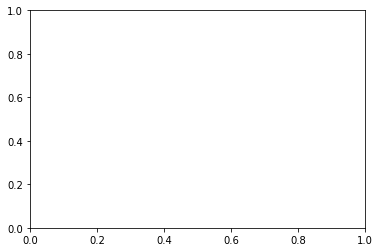

In [25]:
data3=run_TFI(J=.5, g=2.)
chi_list = data3['chi_list']
energy_list = data3['energy_list']
entropy_list = data3['entropy_list']
correlation_list = data3['correlation_list']

log_xi = np.log(correlation_list)
s = entropy_list

def func(log_xi, c, a):
    return (c / 6) * log_xi + a
fitParams, fitCovariances = curve_fit(func, log_xi, s)


chi_list = [int(2**i) for i in np.arange(4, 7, 0.5)]
plt.plot(chi_list, s, 'o', label='iDMRG data')

# logxilist=np.linspace(log_xi[0]-0.1, log_xi[-1]+0.1, 1000)
# slist = [func(lnxi, fitParams[0], fitParams[1]) for lnxi in logxilist]
# plt.plot(logxilist, slist, '-', label=r'fitting $S = \frac{c}{6}\ln\xi + a, c=%.2f, a=%.2f$' % (fitParams[0], fitParams[1]))

plt.xlabel(r'Bond Dimension $\chi$')
plt.ylabel(r'Entanglement Entropy $S$')

plt.legend()

plt.show()
print(fitParams)

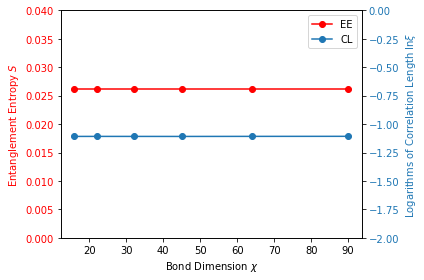

In [64]:
log_xi = np.log(correlation_list)
s = entropy_list


chi_list = [int(2**i) for i in np.arange(4, 7, 0.5)]


fig, ax1 = plt.subplots()

color = 'red'
ax1.set_xlabel(r'Bond Dimension $\chi$')
ax1.set_ylabel(r'Entanglement Entropy $S$', color=color)
line1 = ax1.plot(chi_list, s, '-o', color=color, label='EE')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(bottom=0, top=.04)
# ax1.legend()
# plt.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'Logarithms of Correlation Length $\ln\xi$', color=color)  # we already handled the x-label with ax1
line2 = ax2.plot(chi_list, log_xi, '-o', color=color, label='CL')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(bottom=-2, top=0)
# ax2.legend()
ax1.legend(line1 + line2, [line1[0].get_label(), line2[0].get_label()])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend()
plt.show()